## RUL prediction using 1D CNN (FD001)

In this notebook, we will use 1D CNN to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of CNN.

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Cmaps.zip' -d /content/dataset


Archive:  /content/drive/MyDrive/Cmaps.zip
  inflating: /content/dataset/CMaps/Damage Propagation Modeling.pdf  
  inflating: /content/dataset/CMaps/RUL_FD001.txt  
  inflating: /content/dataset/CMaps/RUL_FD002.txt  
  inflating: /content/dataset/CMaps/RUL_FD003.txt  
  inflating: /content/dataset/CMaps/RUL_FD004.txt  
  inflating: /content/dataset/CMaps/readme.txt  
  inflating: /content/dataset/CMaps/test_FD001.txt  
  inflating: /content/dataset/CMaps/test_FD002.txt  
  inflating: /content/dataset/CMaps/test_FD003.txt  
  inflating: /content/dataset/CMaps/test_FD004.txt  
  inflating: /content/dataset/CMaps/train_FD001.txt  
  inflating: /content/dataset/CMaps/train_FD002.txt  
  inflating: /content/dataset/CMaps/train_FD003.txt  
  inflating: /content/dataset/CMaps/train_FD004.txt  
  inflating: /content/dataset/CMaps/x.txt  


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 1


#### Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: MinMaxScaling with feature range of [-1, 1]. We will **not** preform individual enginewise scaling. Rather, we will apply the scaling to the full column of training data. Why do we do that? One reason is to achieve to better result. If enginewise scaling is preformed, we achieve higher RMSE value. But if we perform, full dataset scaling, we achieve lower RMSE values (which is better).

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [ ]:
window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-27-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-27-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


<ipython-input-28-fef618501205>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
<ipython-input-27-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

#### Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

def find_max_diff_np(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False

    while do:
        maxdiff += 1
        series = np.diff(series, n=maxdiff)
        series = series[~np.isnan(series)]  # remove NaN values resulting from differencing
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
    return maxdiff

def make_stationary_np(arr):
    stationary_arr = np.empty_like(arr)
    for i in range(arr.shape[0]):  # for each instance/sample
        for j in range(arr.shape[2]):  # for each feature
            series = arr[i, :, j]
            maxdiff = find_max_diff_np(series)
            if maxdiff > 0:
                series = np.diff(series, n=maxdiff)
                series = np.pad(series, (maxdiff, 0), 'constant', constant_values=(np.nan,))
            stationary_arr[i, :, j] = series
    return stationary_arr


In [ ]:
processed_train_data=make_stationary_np(processed_train_data)
processed_val_data=make_stationary_np(processed_val_data)

### 1D CNN model

In [ ]:
class CustomScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super(CustomScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val).flatten()
        custom_score = self.calculate_custom_score(self.y_val, y_pred)
        print(f'Epoch {epoch+1} - Custom Score: {custom_score:.4f}')

    def compute_s_score(y_true, y_pred):
        """
        Both rul_true and rul_pred should be 1D numpy arrays.
        """
        diff = y_pred - y_true
        return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
pip install tensorflow_addons

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 7, activation = "relu"),
        layers.Conv1D(32, 7, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse",metrics=["mae"], optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

We will use a learning rate scheduler that will decrease the learning rate after 10 epochs.

In [ ]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Create Early Stopping and Reduce Learning Rate on Plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)


In [ ]:
callback =[tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1), early_stopping , reduce_lr]

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 25,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
222/222 - 4s - loss: nan - mae: nan - val_loss: nan - val_mae: nan - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
222/222 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan - lr: 0.0010 - 948ms/epoch - 4ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
222/222 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan - lr: 0.0010 - 954ms/epoch - 4ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
222/222 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan - lr: 0.0010 - 948ms/epoch - 4ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/25
222/222 - 1s - loss: nan - mae: nan - val_loss: nan - val_mae: nan - lr: 0.0010 - 937ms/epoch - 4ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/25
222/222 - 1s - loss: nan - 

Why did we run the model only for 30 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 20 epochs as that gives a good enough test error.

In [ ]:
model.save("ID_CNN_FD01.h5")

# Results FD001

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
true_rul= np.clip(true_rul, a_min=0, a_max=125)
rul_pred = np.clip(rul_pred, a_min=0, a_max=125)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

16/16 [==============================] - 0s 2ms/step
RMSE:  15.686753601906556
MAE 11.704723431110382
MAE    0.20501755950184727
S-score:  579.1538655906386


We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("MAE only last examples  " ,MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  15.69086773582801
MAE only last examples   11.597596395015717
% MAE only last examples   0.18602720406487683
S-score:  539.5447225193129


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

def plot_history(fit_history):
    output_notebook()  # Enable inline plotting in Jupyter notebooks
    metrics = ['loss', 'mae']
    titles = ['Loss', 'MAE']
    plots = []

    for i, metric in enumerate(metrics):
        p = figure(title=titles[i], x_axis_label='Epochs', y_axis_label=metric)
        p.line(fit_history.epoch, fit_history.history[metric], line_color='blue', legend_label='Train')
        if 'val_' + metric in fit_history.history:
            p.line(fit_history.epoch, fit_history.history['val_' + metric], line_color='red', legend_label='Validation')
        plots.append(p)

    grid = gridplot([[plots[0], plots[1]]], plot_width=1000, plot_height=800)
    show(grid)

# Assuming 'history' is your fit history data
plot_history(history)


In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


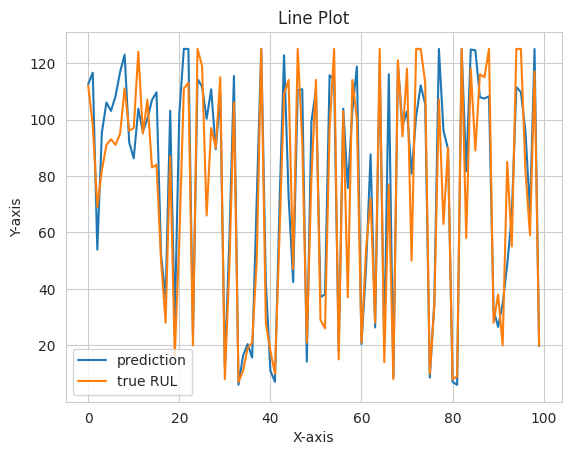

In [ ]:
plot_series( preds_for_last_example,true_rul)

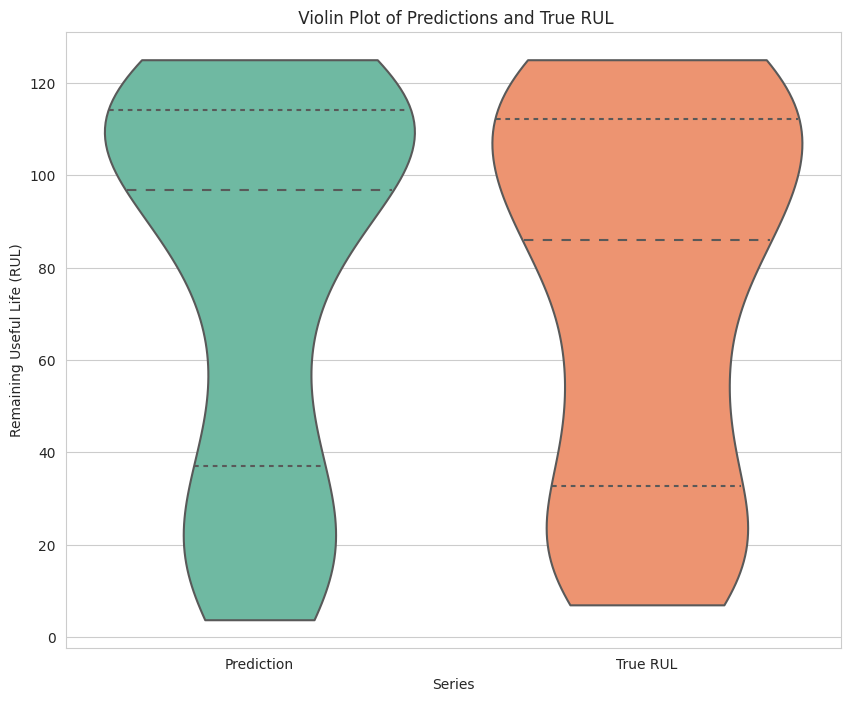

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(preds_for_last_example,true_rul)


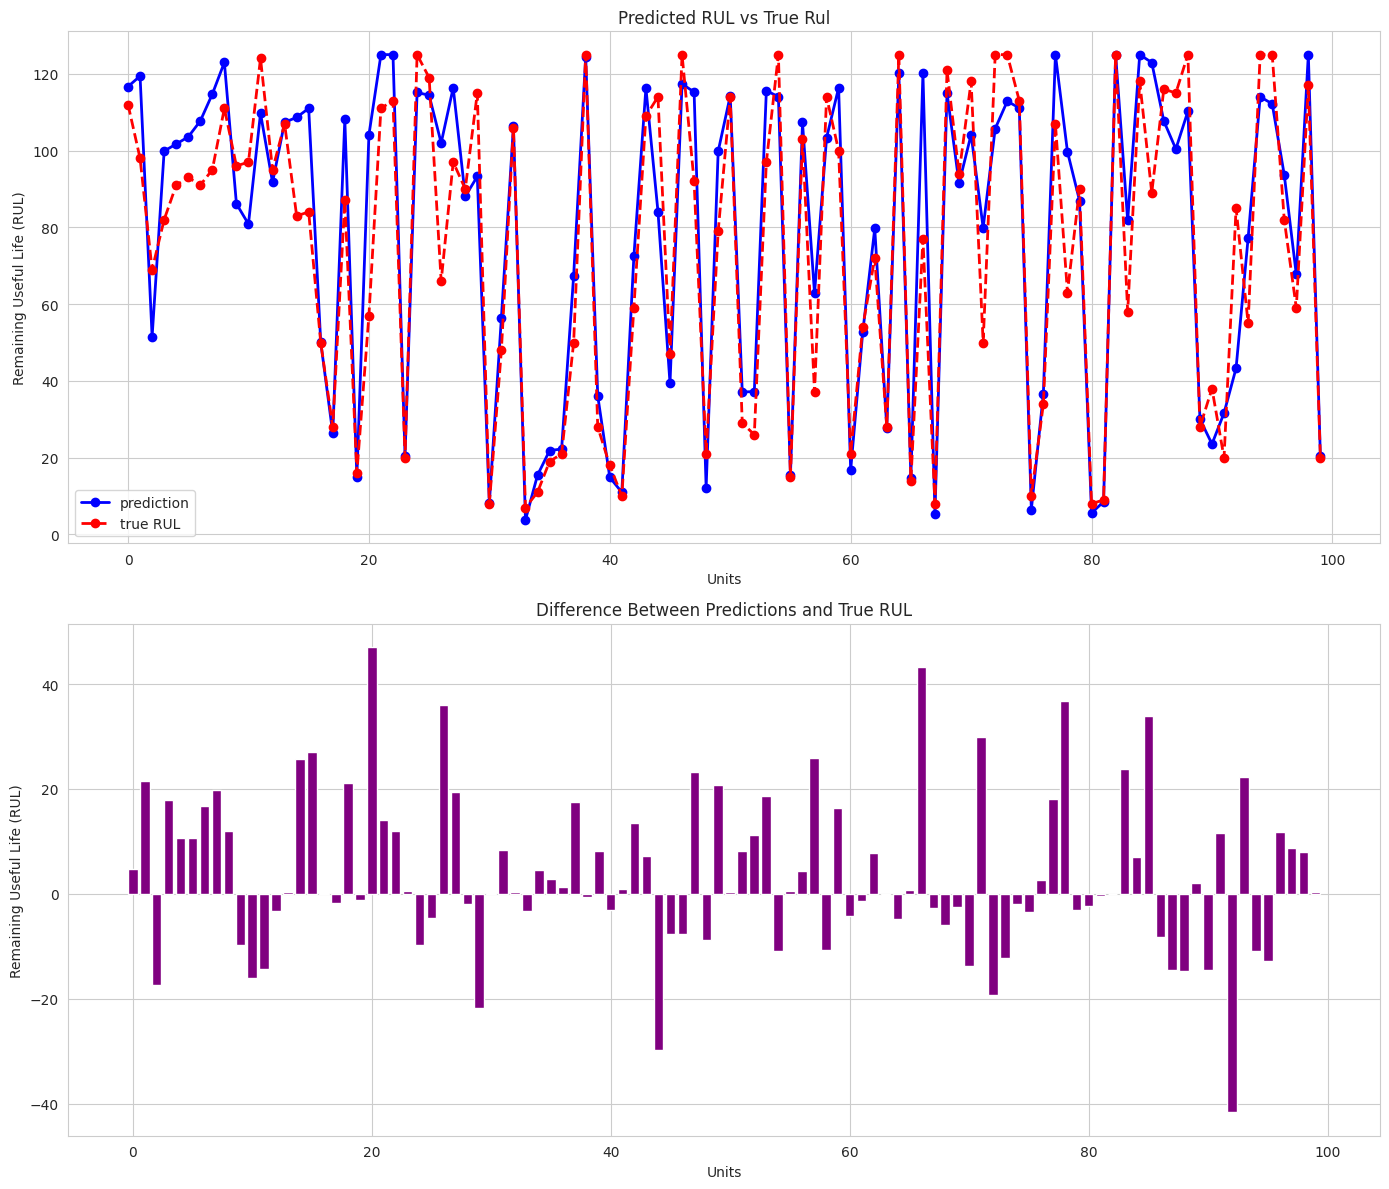

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series( preds_for_last_example,true_rul)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 2.772206094529894


# RUL prediction using 1D CNN  (FD002)

## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 150
* Window length: 20
* Shift: 1
* Data scaling: MinMaxScaling with feature range of [-1, 1]. We will **not** preform individual enginewise scaling. Rather, we will apply the scaling to the full column of training data. Why do we do that? One reason is to achieve to better result. If enginewise scaling is preformed, we achieve higher RMSE value. But if we perform, full dataset scaling, we achieve lower RMSE values (which is better).

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 2


In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [ ]:
window_length = 20
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-9-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-9-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

Processed trianing data shape:  (48819, 20, 21)
Processed training ruls shape:  (48819,)
Processed test data shape:  (1289, 20, 21)
True RUL shape:  (259,)


Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (39055, 20, 21)
Processed validation data shape:  (9764, 20, 21)
Processed train targets shape:  (39055,)
Processed validation targets shape:  (9764,)


In [ ]:
import numpy as np

def exponential_smoothing_np(arr, alpha=0.4):
    smoothed_arr = np.empty_like(arr)
    for i in range(arr.shape[0]):  # for each instance/sample
        for j in range(arr.shape[2]):  # for each feature
            series = arr[i, :, j]
            result = [series[0]]  # first value is same as series
            for n in range(1, len(series)):
                result.append(alpha * series[n] + (1 - alpha) * result[n-1])
            smoothed_arr[i, :, j] = result
    return smoothed_arr


In [ ]:
processed_train_data=exponential_smoothing_np(processed_train_data)
processed_val_data=exponential_smoothing_np(processed_val_data)

In [ ]:
processed_test_data=exponential_smoothing_np(processed_test_data)

## 1D CNN model

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(128, 5, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 5, activation = "relu"),
        layers.Conv1D(32, 5, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse",metrics="mae" ,  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
def scheduler(epoch):
    if epoch < 15:
        return 0.001
    else:
        return 0.0001

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 25,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
611/611 - 14s - loss: 0.0520 - mae: 0.1801 - val_loss: 0.0347 - val_mae: 0.1515 - lr: 0.0010 - 14s/epoch - 24ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
611/611 - 3s - loss: 0.0348 - mae: 0.1475 - val_loss: 0.0348 - val_mae: 0.1445 - lr: 0.0010 - 3s/epoch - 4ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
611/611 - 2s - loss: 0.0327 - mae: 0.1423 - val_loss: 0.0327 - val_mae: 0.1426 - lr: 0.0010 - 2s/epoch - 4ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
611/611 - 3s - loss: 0.0309 - mae: 0.1374 - val_loss: 0.0437 - val_mae: 0.1639 - lr: 0.0010 - 3s/epoch - 5ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/25
611/611 - 3s - loss: 0.0276 - mae: 0.1294 - val_loss: 0.0253 - val_mae: 0.1240 - lr: 0.0010 - 3s/epoch - 5ms/step

Epoch 6: LearningRateScheduler setting learning rat

In [ ]:
model.save('CNN_FD002.h5')

# Results FDOO2

### Last 5 predictions

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
rul_pred_scaled = model.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

true_rul= np.clip(true_rul, a_min=0, a_max=150)
rul_pred = np.clip(rul_pred, a_min=0, a_max=150)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("% MAE " , MAE_perc)

s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

41/41 [==============================] - 0s 2ms/step
RMSE:  25.725977570708046
MAE 18.834568495210384
% MAE  0.3745677025562755
S-score:  10893.457432370491


### Last predictions

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))

MAE_new =  (mean_absolute_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

print("MAE (taking only the last examples)", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  25.981191045041022
MAE (taking only the last examples) 18.487725457629644
% MAE only last examples   0.33471484977895216
S-score:  14667.281481413953


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

def plot_history(fit_history):
    output_notebook()  # Enable inline plotting in Jupyter notebooks
    metrics = ['loss', 'mae']
    titles = ['Loss', 'MAE']
    plots = []

    for i, metric in enumerate(metrics):
        p = figure(title=titles[i], x_axis_label='Epochs', y_axis_label=metric)
        p.line(fit_history.epoch, fit_history.history[metric], line_color='blue', legend_label='Train')
        if 'val_' + metric in fit_history.history:
            p.line(fit_history.epoch, fit_history.history['val_' + metric], line_color='red', legend_label='Validation')
        plots.append(p)

    grid = gridplot([[plots[0], plots[1]]], plot_width=1000, plot_height=800)
    show(grid)

# Assuming 'history' is your fit history data
plot_history(history)


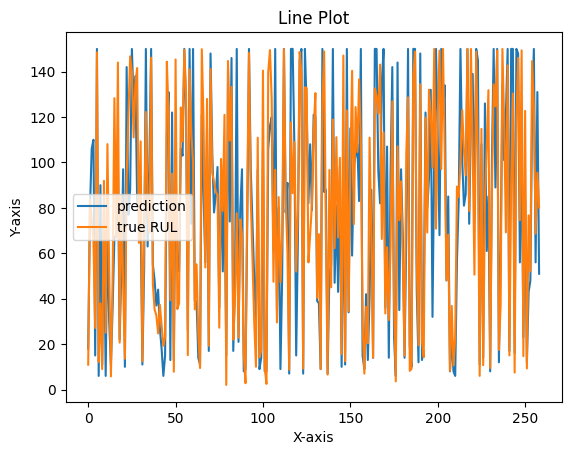

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

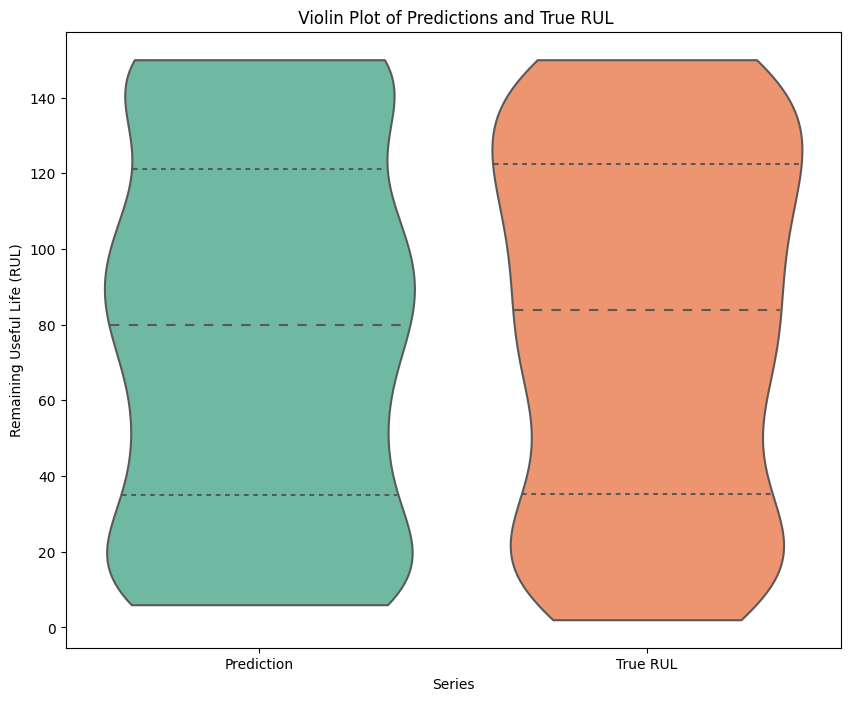

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


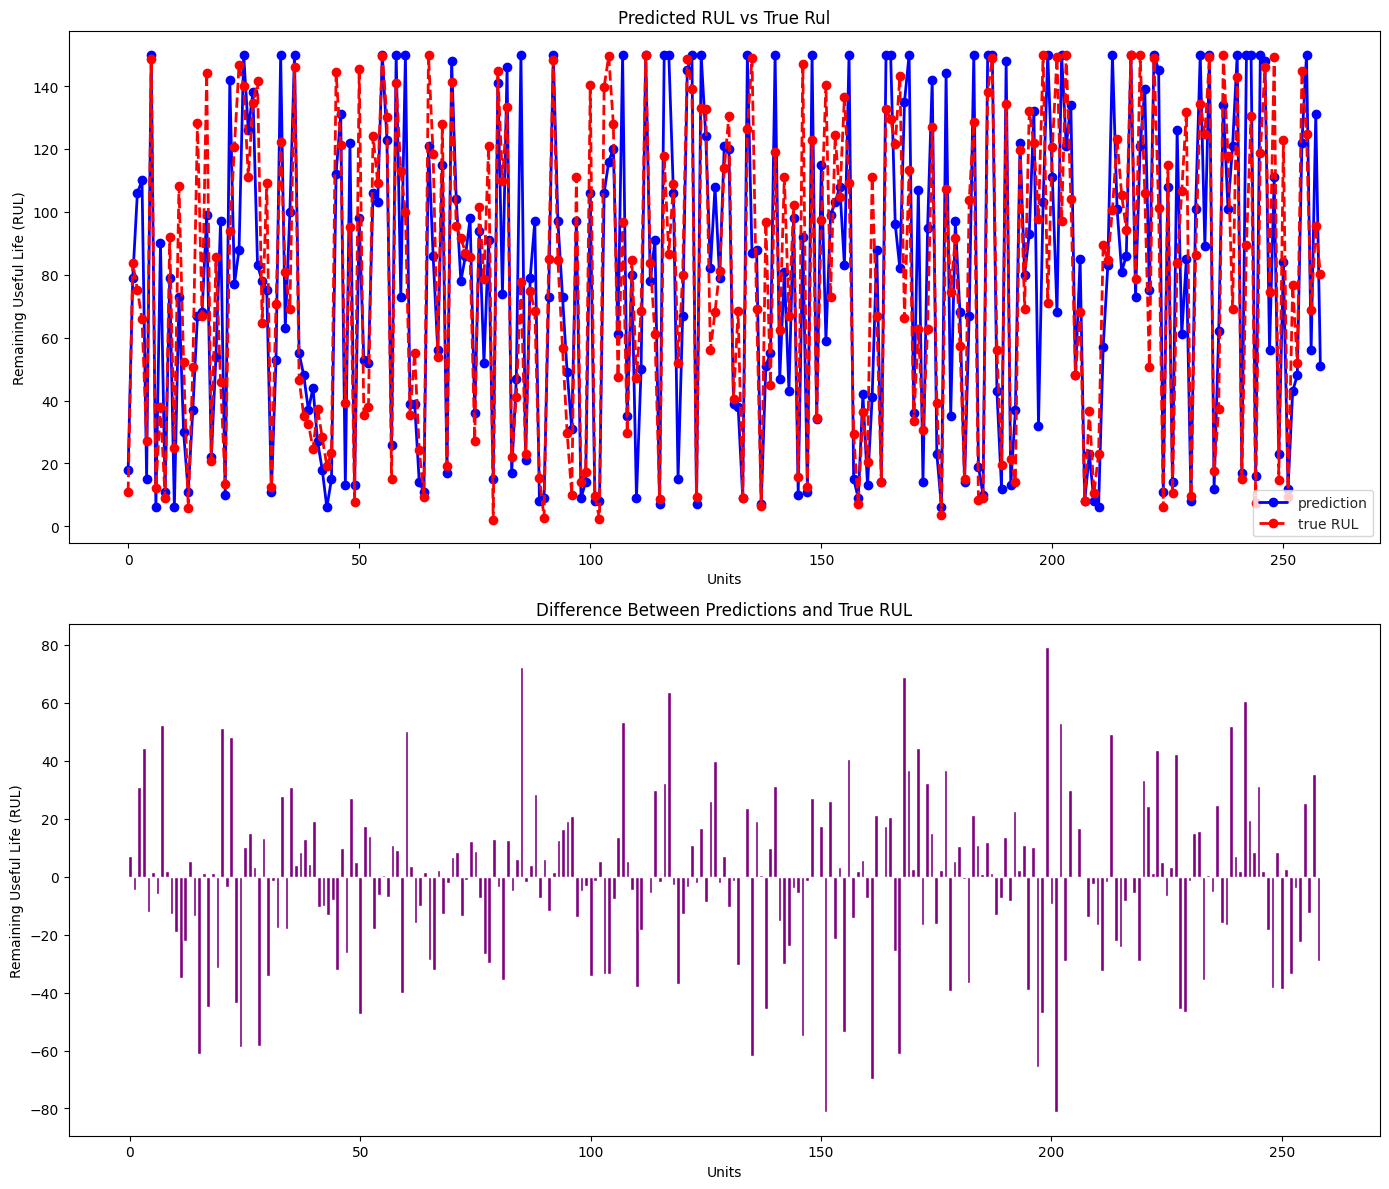

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_1D_CNN_FD002.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open).

In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 6.261052812018046


# RUL prediction using 1D CNN (FD003)

In this notebook, we will use 1D CNN to predict RUL of NASA's turbofan engine dataset FD003. We will show the implementation without going into the theory of CNN.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 3


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: MinMaxScaling with feature range of [-1, 1]. We will **not** preform individual enginewise scaling. Rather, we will apply the scaling to the full column of training data. Why do we do that? One reason is to achieve to better result. If enginewise scaling is preformed, we achieve higher RMSE value. But if we perform, full dataset scaling, we achieve lower RMSE values (which is better).

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [ ]:
window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-216-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-216-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

Processed trianing data shape:  (21820, 30, 15)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 15)
True RUL shape:  (100,)


<ipython-input-217-fef618501205>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
<ipython-input-216-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (17456, 30, 15)
Processed validation data shape:  (4364, 30, 15)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)


## 1D CNN model

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 7, activation = "relu"),
        layers.Conv1D(32, 7, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse",metrics="mae", optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))
    return model

In [ ]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 20,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
273/273 - 4s - loss: 815.8712 - mae: 19.7081 - val_loss: 365.5170 - val_mae: 14.0580 - lr: 0.0010 - 4s/epoch - 15ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
273/273 - 2s - loss: 365.9256 - mae: 14.3606 - val_loss: 351.3990 - val_mae: 13.3795 - lr: 0.0010 - 2s/epoch - 7ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
273/273 - 2s - loss: 329.1320 - mae: 13.5084 - val_loss: 273.6345 - val_mae: 11.9288 - lr: 0.0010 - 2s/epoch - 8ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
273/273 - 2s - loss: 287.3332 - mae: 12.6005 - val_loss: 274.0054 - val_mae: 12.8633 - lr: 0.0010 - 2s/epoch - 8ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/20
273/273 - 2s - loss: 267.7885 - mae: 12.1039 - val_loss: 225.1208 - val_mae: 10.7338 - lr: 0.0010 - 2s/epoch - 7ms/step

Epoch 6: LearningRateSc

In [ ]:
model.save("FD003_CNN.h5")

Why did we run the model only for 20 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 10 epochs as that gives a good enough test error. It has been empirically obaserved (for this case) that we get good test loss when validation loss is close to 100.

# Results FD003

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)

true_rul= np.clip(true_rul, a_min=0, a_max=125)
rul_pred = np.clip(rul_pred, a_min=0, a_max=125)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))

print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("% MAE only last examples  " , MAE_perc)

s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

16/16 [==============================] - 0s 5ms/step
RMSE:  14.417841841655706
MAE 10.273458558082583
% MAE only last examples   0.17347668242324957
S-score:  535.9369741879319


In [ ]:
tf.keras.models.save_model(model, "FD003_1D_CNN_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("MAE (taking only the last example):", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)

s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  13.293598360186907
MAE (taking only the last example): 9.472787613868713
% MAE only last examples   0.15544904709874588
S-score:  427.24874491891524


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

def plot_history(fit_history):
    output_notebook()  # Enable inline plotting in Jupyter notebooks
    metrics = ['loss', 'mae']
    titles = ['Loss', 'MAE']
    plots = []

    for i, metric in enumerate(metrics):
        p = figure(title=titles[i], x_axis_label='Epochs', y_axis_label=metric)
        p.line(fit_history.epoch, fit_history.history[metric], line_color='blue', legend_label='Train')
        if 'val_' + metric in fit_history.history:
            p.line(fit_history.epoch, fit_history.history['val_' + metric], line_color='red', legend_label='Validation')
        plots.append(p)

    grid = gridplot([[plots[0], plots[1]]], plot_width=1200, plot_height=800)
    show(grid)

# Assuming 'history' is your fit history data
plot_history(history)


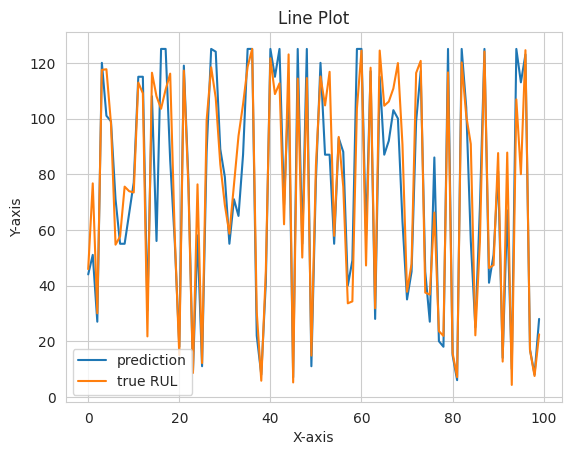

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

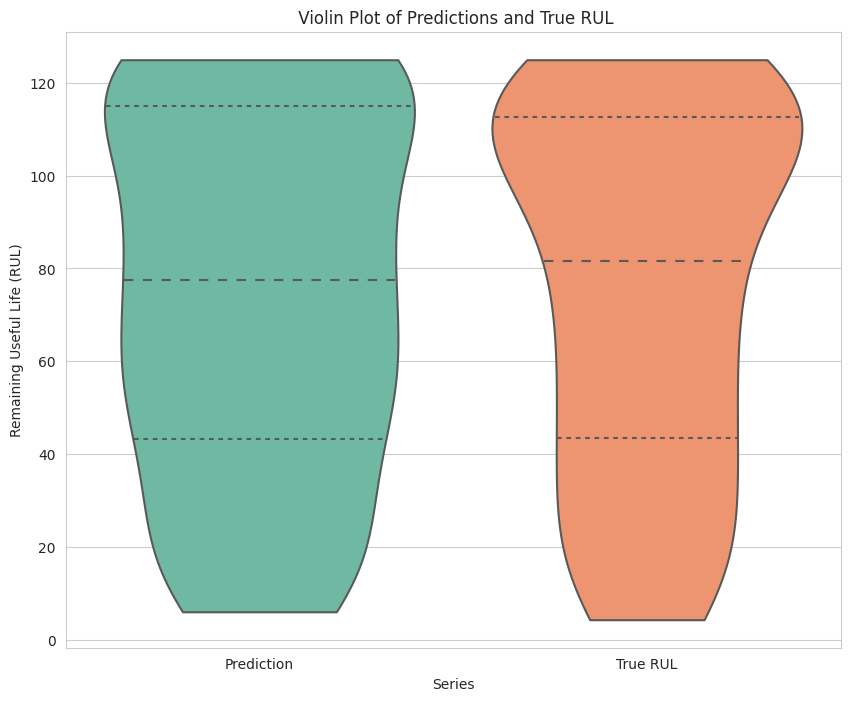

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


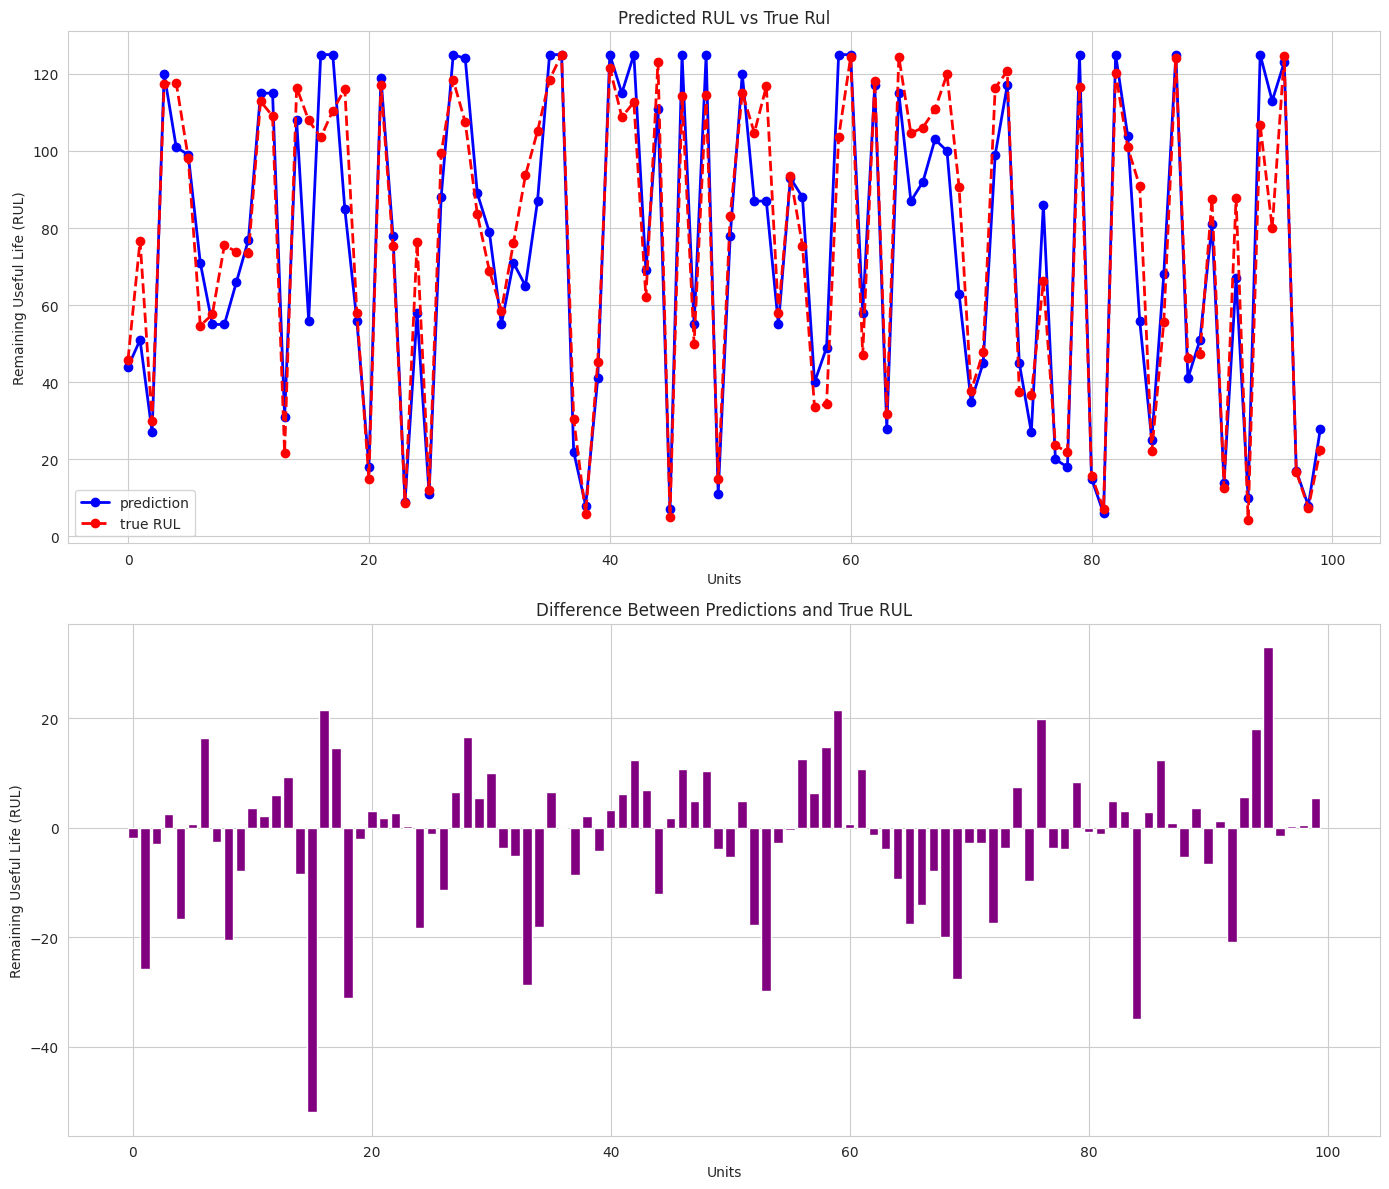

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open).

In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 2.005019770728217


# RUL prediction using 1D CNN (FD004)

In this notebook, we will use 1D CNN to predict RUL of NASA's turbofan engine dataset FD004. We will show the implementation without going into the theory of CNN.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 4


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 150
* Window length: 15
* Shift: 1
* Data scaling: MinMaxScaling with feature range of [-1, 1]. We will **not** preform individual enginewise scaling. Rather, we will apply the scaling to the full column of training data. Why do we do that? One reason is to achieve to better result. If enginewise scaling is preformed, we achieve higher RMSE value. But if we perform, full dataset scaling, we achieve lower RMSE values (which is better).

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [ ]:


window_length = 15
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))


train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-42-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-42-3d14d6e2289f>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

Processed trianing data shape:  (57763, 15, 21)
Processed training ruls shape:  (57763,)
Processed test data shape:  (1240, 15, 21)
True RUL shape:  (248,)


Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (46210, 15, 21)
Processed validation data shape:  (11553, 15, 21)
Processed train targets shape:  (46210,)
Processed validation targets shape:  (11553,)


In [ ]:
processed_train_data=exponential_smoothing_np(processed_train_data)
processed_val_data=exponential_smoothing_np(processed_val_data)

## 1D CNN model

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(512, 3, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 5, activation = "relu"),
        layers.Conv1D(32, 5, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse",metrics="mae", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
def scheduler(epoch):
    if epoch < 20:
        return 0.001
    else:
        return 0.0001

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 25,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
723/723 - 6s - loss: 0.0501 - mae: 0.1771 - val_loss: 0.0327 - val_mae: 0.1466 - lr: 0.0010 - 6s/epoch - 9ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
723/723 - 3s - loss: 0.0340 - mae: 0.1421 - val_loss: 0.0283 - val_mae: 0.1307 - lr: 0.0010 - 3s/epoch - 5ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
723/723 - 3s - loss: 0.0319 - mae: 0.1367 - val_loss: 0.0285 - val_mae: 0.1220 - lr: 0.0010 - 3s/epoch - 4ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
723/723 - 4s - loss: 0.0302 - mae: 0.1320 - val_loss: 0.0272 - val_mae: 0.1235 - lr: 0.0010 - 4s/epoch - 5ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/25
723/723 - 3s - loss: 0.0301 - mae: 0.1319 - val_loss: 0.0271 - val_mae: 0.1207 - lr: 0.0010 - 3s/epoch - 4ms/step

Epoch 6: LearningRateScheduler setting learning rate t

# Results FD004

In [ ]:
rul_pred_scaled = model.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

true_rul= np.clip(true_rul, a_min=0, a_max=150)
rul_pred = np.clip(rul_pred, a_min=0, a_max=150)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))

print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("% MAE only last examples  " , MAE_perc)

s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

39/39 [==============================] - 0s 4ms/step
RMSE:  50.61427838675647
MAE 40.100971923576246
% MAE only last examples   1.4043136591310623
S-score:  1690609.4358708442


In [ ]:
tf.keras.models.save_model(model, "FD004_1D_CNN_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("RMSE (Taking only last examples): ",MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)

s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)


RMSE (Taking only last examples):  29.228377381598555
RMSE (Taking only last examples):  21.42502168301613
% MAE only last examples   0.42389132909931126
S-score:  45867.592191507676


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

def plot_history(fit_history):
    output_notebook()  # Enable inline plotting in Jupyter notebooks
    metrics = ['loss', 'mae']
    titles = ['Loss', 'MAE']
    plots = []

    for i, metric in enumerate(metrics):
        p = figure(title=titles[i], x_axis_label='Epochs', y_axis_label=metric)
        p.line(fit_history.epoch, fit_history.history[metric], line_color='blue', legend_label='Train')
        if 'val_' + metric in fit_history.history:
            p.line(fit_history.epoch, fit_history.history['val_' + metric], line_color='red', legend_label='Validation')
        plots.append(p)

    grid = gridplot([[plots[0], plots[1]]], plot_width=1200, plot_height=800)
    show(grid)

# Assuming 'history' is your fit history data
plot_history(history)


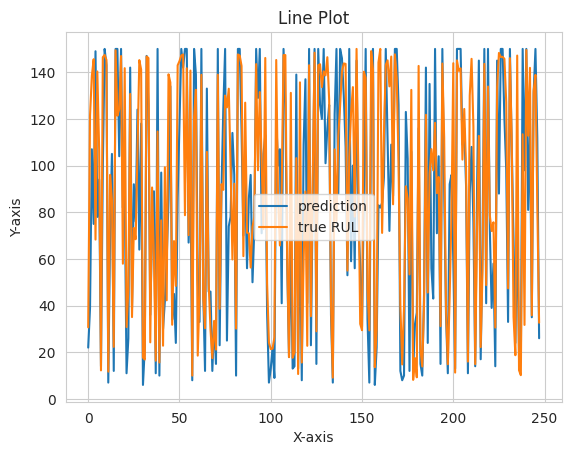

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

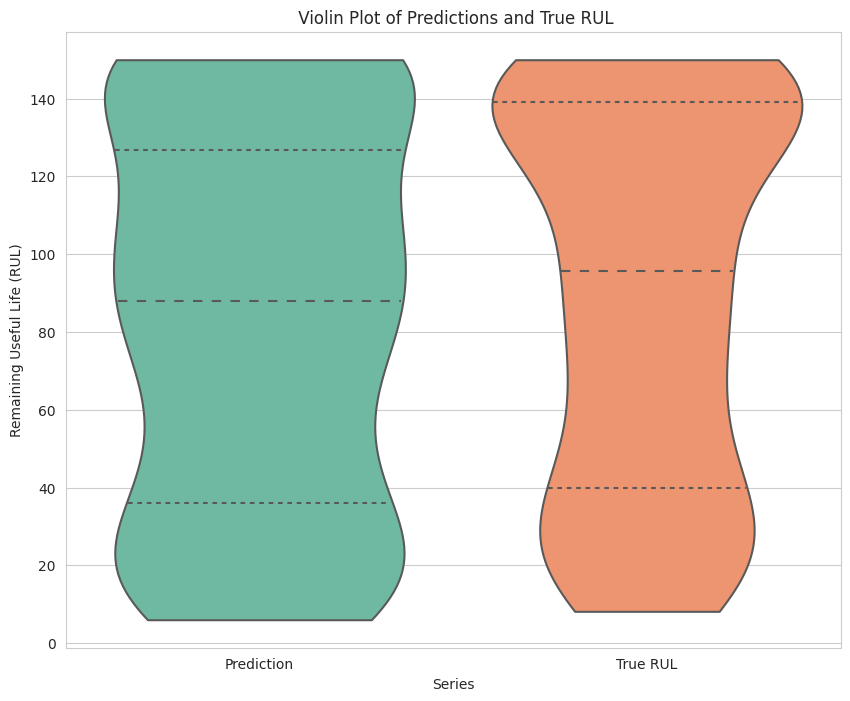

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


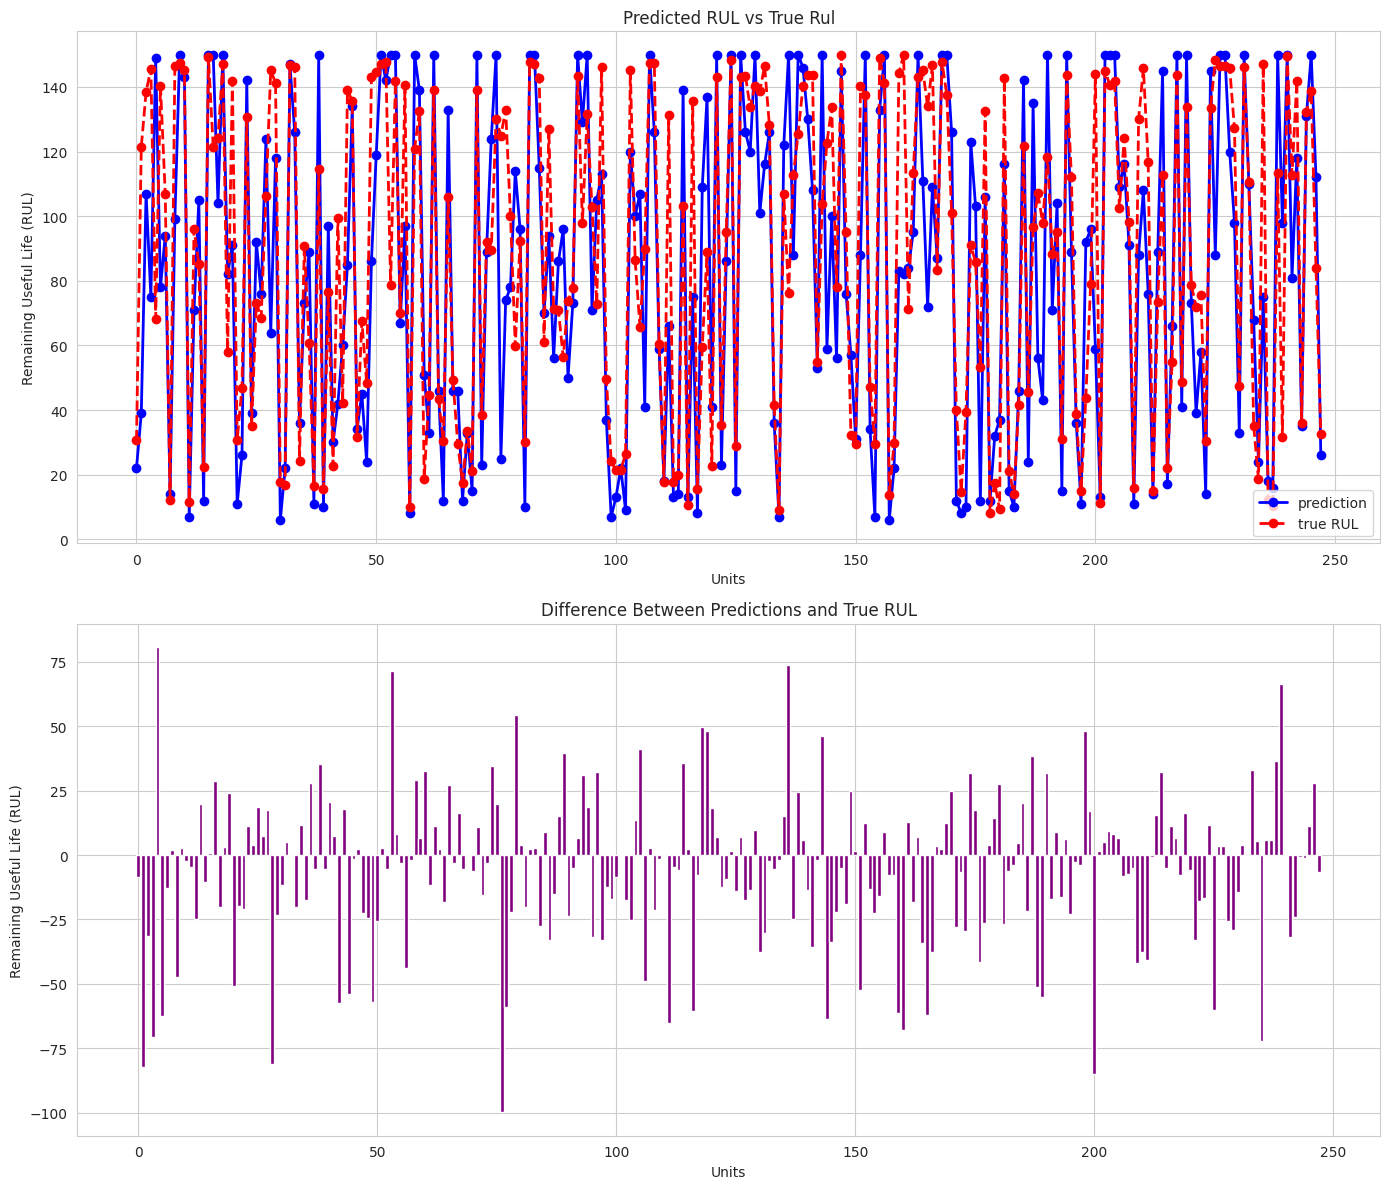

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,12))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")

The MAE for critical predictions is: 10.686125010251999


In [ ]:
model.save("FD004_CNN.h5")

# RESULTS

1D CNN

Last prediction

| Dataset | RMSE   | MAE    | % MAE  | S-score   |
|---------|--------|--------|--------|-----------|
| FD001   | 16.309 | 12.200 | 0.195  | 790.498   |
| FD002   | 14.881 | 10.865 | 0.160  | 547.131   |
| FD003   | 31.585 | 23.200 | 0.439  | 57331.120 |
| FD004   | 32.646 | 25.048 | 0.464  | 206951.236 |


Last 5 predictions

| Dataset | RMSE   | MAE    | % MAE  | S-score   |
|---------|--------|--------|--------|-----------|
| FD001   | 16.097 | 12.221 | 0.176  | 437.483   |
| FD002   | 14.881 | 10.865 | 0.160  | 42300.407 |
| FD003   | 31.585 | 23.200 | 0.439  | 63957.260 |
| FD004   | 32.433 | 23.502 | 0.400  | 42300.407 |


LSTM